<a href="https://colab.research.google.com/github/omendez930/Bank-Fraud-Detection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bank Fraud Detection**

# Business Understanding

Objective:

The primary goal of analyzing this dataset is to detect fraudulent bank transactions. Fraudulent activities can cause significant financial losses for banks and customers. By leveraging machine learning and data analysis, we aim to build a model that can distinguish between legitimate and fraudulent transactions in real time.



*   A high-performing fraud detection model that minimizes false positives (legitimate transactions incorrectly flagged as fraud) and false negatives (fraudulent transactions that go undetected).
*   The model should generalize well to unseen data to be deployable in a real-world setting.
*   Business value: reducing financial losses due to fraud and enhancing customer trust in the bank’s security systems.

# Data Understanding

Key Features to Examine:

The dataset contains 200k rows of transactional data labeled as fraudulent or non-fraudulent. Each row represents a transaction with various features describing its characteristics.



1.   Gender: The gender of the consumer (e.G., Male, Female, Other). Four.
2.   Age: The age of the consumer at the time of the transaction.
3.   State: The nation in which the patron resides.
4.   Bank_Branch: The specific financial institution branch wherein the consumer holds their account.
5.   Account_Type: The kind of account held with the aid of the customer (e.G., Savings, Checking). Nine.
6.   Transaction_ID: A particular identifier for each transaction.
7.   Transaction_Date: The date on which the transaction passed off. Eleven.
8.   Transaction_Time: The specific time the transaction became initiated.
9.   Transaction_Amount: The financial value of the transaction.
10.  Merchant_ID: A particular identifier for the merchant worried within the transaction.
11.  Transaction_Type: The nature of the transaction (e.G., Withdrawal, Deposit, Transfer).
12.   Merchant_Category: The class of the merchant (e.G., Retail, Online, Travel).
13.   Account_Balance: The balance of the customer's account after the transaction.
14.   Transaction_Device: The tool utilized by the consumer to perform the transaction (e.G., Mobile, Desktop).
15.   Transaction_Location: The geographical vicinity (e.G., latitude, longitude) of the transaction.
16.   Device_Type: The kind of device used for the transaction (e.G., Smartphone, Laptop).
17.   Is_Fraud: A binary indicator (1 or zero) indicating whether or not the transaction is fraudulent or now not.
18.   Transaction_Currency: The currency used for the transaction (e.G., USD, EUR).
19.   Transaction_Description: A brief description of the transaction (e.G., buy, switch).







In [ ]:
# Uncomment if you open this file in google colab
# !kaggle datasets download -d orangelmendez/bank-fraud

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Uncomment to unzip the file in google colab
# !unzip bank-fraud.zip -d data

In [3]:
pip install tensorflow

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
     ---------------------------------------- 0.0/48.6 kB ? eta -:--:--
     ---------------------------------------- 48.6/48.6 kB 2.4 MB/s eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 1.8/390.3 MB 38.5 MB/s eta 0:00:11
   ---------------------------------------- 4.2/390.3 MB 44.7 MB/s eta 0:00:09
    --------------------------------------- 6.3/390.3 MB 50.2 MB/s eta 0:00:08
    --------------------------------------- 8.4/390.3 MB 44.6 MB/s eta 0:00:09
   - --------------------------

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import classification_report, roc_auc_score, classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Data Preprocessing

In [2]:
# bank_df = pd.read_csv('./data/new_bank_fraud_detection.csv', encoding='utf-8', index_col=0)
bank_df = pd.read_csv('./data/new_bank_fraud_detection.csv', index_col=0)
bank_df.head()

,Gender,Age,State,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,Transaction_Time,Transaction_Amount,Merchant_ID,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Transaction_Description
0,Male,60,Kerala,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,16:04:07,32415.45,214e03c5-5c34-40d1-a66c-f440aa2bbd02,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,Bitcoin transaction
1,Female,51,Maharashtra,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,17:14:53,43622.60,f9e3f11f-28d3-4199-b0ca-f225a155ede6,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,Grocery delivery
2,Male,20,Bihar,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,25-01-2025,03:09:52,63062.56,97977d83-5486-4510-af1c-8dada3e1cfa0,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,Mutual fund investment
3,Female,57,Tamil Nadu,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,19-01-2025,12:27:02,14000.72,f45cd6b3-5092-44d0-8afb-490894605184,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,Food delivery
4,Female,43,Punjab,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,30-01-2025,18:30:46,18335.16,70dd77dd-3b00-4b2c-8ebc-cfb8af5f6741,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,Debt repayment


In [3]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 199999
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Gender                   200000 non-null  object 
 1   Age                      200000 non-null  int64  
 2   State                    200000 non-null  object 
 3   Bank_Branch              200000 non-null  object 
 4   Account_Type             200000 non-null  object 
 5   Transaction_ID           200000 non-null  object 
 6   Transaction_Date         200000 non-null  object 
 7   Transaction_Time         200000 non-null  object 
 8   Transaction_Amount       200000 non-null  float64
 9   Merchant_ID              200000 non-null  object 
 10  Transaction_Type         200000 non-null  object 
 11  Merchant_Category        200000 non-null  object 
 12  Account_Balance          200000 non-null  float64
 13  Transaction_Device       200000 non-null  object 
 14  Transacti

In [4]:
bank_df.describe()

,Age,Transaction_Amount,Account_Balance,Is_Fraud
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,44.015110,49538.015554,52437.988784,0.050440
std,15.288774,28551.874004,27399.507128,0.218852
min,18.000000,10.290000,5000.820000,0.000000
25%,31.000000,24851.345000,28742.395000,0.000000
50%,44.000000,49502.440000,52372.555000,0.000000
75%,57.000000,74314.625000,76147.670000,0.000000
max,70.000000,98999.980000,99999.950000,1.000000


In [5]:
bank_df.columns

Index(['Gender', 'Age', 'State', 'Bank_Branch', 'Account_Type',
       'Transaction_ID', 'Transaction_Date', 'Transaction_Time',
       'Transaction_Amount', 'Merchant_ID', 'Transaction_Type',
       'Merchant_Category', 'Account_Balance', 'Transaction_Device',
       'Transaction_Location', 'Device_Type', 'Is_Fraud',
       'Transaction_Currency', 'Transaction_Description'],
      dtype='object')

In [6]:
bank_df.drop(columns=['Gender','Age'], inplace=True)

In [7]:
bank_df.isnull().sum()

State                      0
Bank_Branch                0
Account_Type               0
Transaction_ID             0
Transaction_Date           0
Transaction_Time           0
Transaction_Amount         0
Merchant_ID                0
Transaction_Type           0
Merchant_Category          0
Account_Balance            0
Transaction_Device         0
Transaction_Location       0
Device_Type                0
Is_Fraud                   0
Transaction_Currency       0
Transaction_Description    0
dtype: int64

In [8]:
bank_df.dtypes

State                       object
Bank_Branch                 object
Account_Type                object
Transaction_ID              object
Transaction_Date            object
Transaction_Time            object
Transaction_Amount         float64
Merchant_ID                 object
Transaction_Type            object
Merchant_Category           object
Account_Balance            float64
Transaction_Device          object
Transaction_Location        object
Device_Type                 object
Is_Fraud                     int64
Transaction_Currency        object
Transaction_Description     object
dtype: object

Let's combine the "Transaction_Date" and "Transaction_Time" columns together, and convert it into a datetime dtype.

In [9]:
bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_Date']+" "+bank_df['Transaction_Time'])
bank_df[['Transaction_Date','Transaction_Time']]

bank_df.dtypes

C:\Users\omend\AppData\Local\Temp\ipykernel_7152\2319926438.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_Date']+" "+bank_df['Transaction_Time'])


State                              object
Bank_Branch                        object
Account_Type                       object
Transaction_ID                     object
Transaction_Date                   object
Transaction_Time                   object
Transaction_Amount                float64
Merchant_ID                        object
Transaction_Type                   object
Merchant_Category                  object
Account_Balance                   float64
Transaction_Device                 object
Transaction_Location               object
Device_Type                        object
Is_Fraud                            int64
Transaction_Currency               object
Transaction_Description            object
Transaction_DateTime       datetime64[ns]
dtype: object

In [10]:
# Drop the date and time columns
# bank_df.drop(columns=['Transaction_Date', 'Transaction_Time'], axis=1)
# bank_df.dtypes

# **Exploratory Data Analysis**

## Visualizations

We'll start with some descriptive statistics. We'll visualize the distribution of fraudulent transactions that occur within the data. This shows the class distribution and helps you check if the data is imbalanced.

Next, lets check the distribution of Transaction Amounts. This helps visualize the distribution of transaction amounts and understand any skewness.

## **Fraud Distribution**

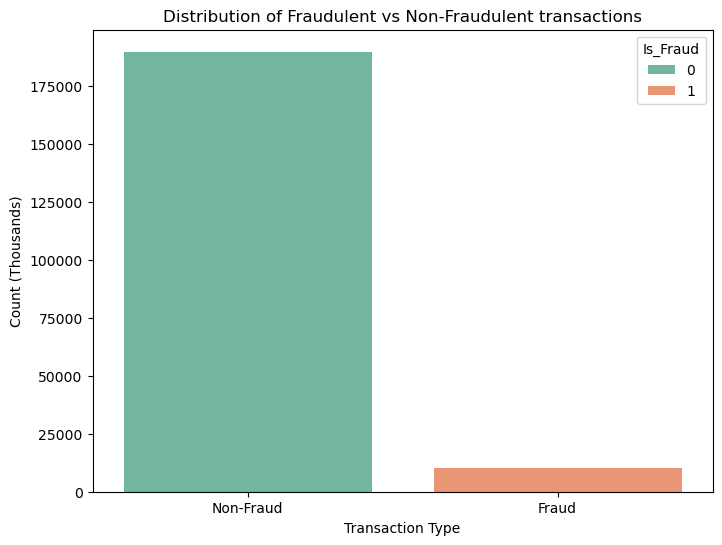

In [11]:
plt.figure(figsize=(8,6))
sns.countplot(x='Is_Fraud', data=bank_df, palette='Set2', hue='Is_Fraud')
plt.title('Distribution of Fraudulent vs Non-Fraudulent transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count (Thousands)')
plt.xticks([0,1], ['Non-Fraud','Fraud'])
plt.show()


## **Distribution of Transaction Amounts**

This histplot can help assess distribution between the transaction amount and whether the transaction is fraudulent or not.

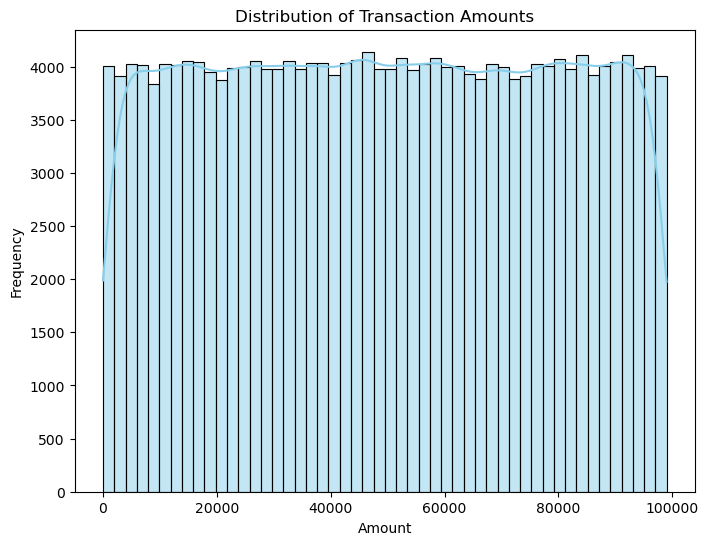

In [12]:
plt.figure(figsize=(8,6))
sns.histplot(bank_df['Transaction_Amount'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


C:\Users\omend\AppData\Local\Temp\ipykernel_7152\1669695059.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Is_Fraud', y='Transaction_Amount', data=bank_df, palette='Set2')


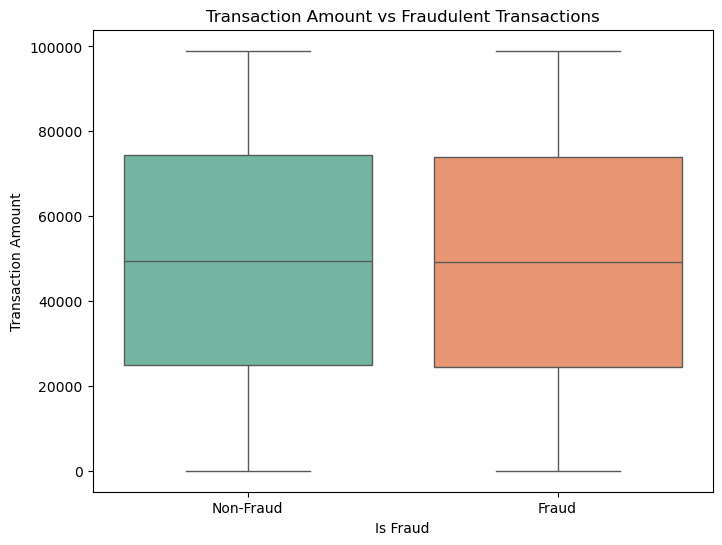

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Is_Fraud', y='Transaction_Amount', data=bank_df, palette='Set2')
plt.title('Transaction Amount vs Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

## **Fraud by Transaction Type**

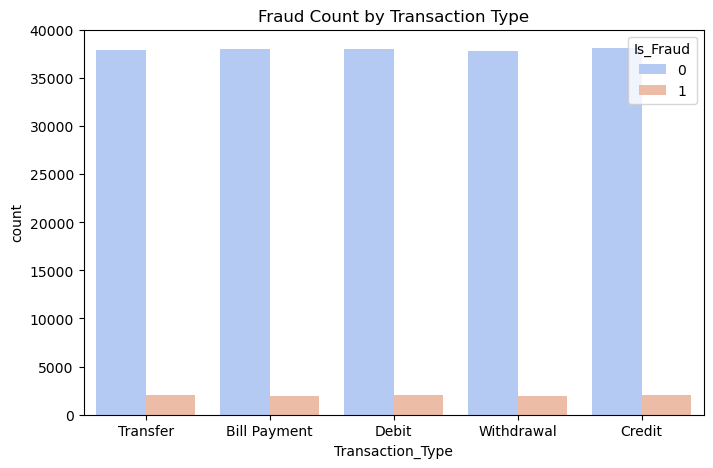

In [14]:
plt.figure(figsize=(8,5))
sns.countplot(data=bank_df, x='Transaction_Type', hue='Is_Fraud', palette='coolwarm')
plt.title("Fraud Count by Transaction Type")
plt.show()

## **Time-Based Analysis**

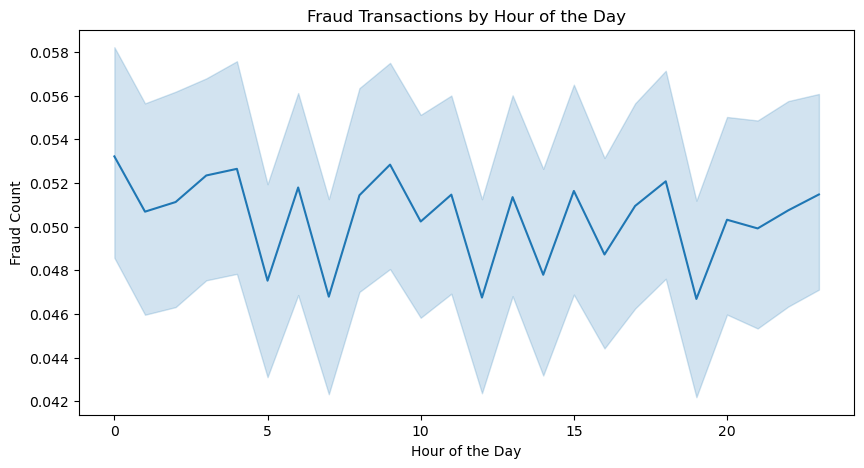

In [15]:
if 'Transaction_DateTime' in bank_df.columns:
    bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_DateTime'])
    bank_df.set_index('Transaction_DateTime', inplace=True)
    bank_df['hour'] = bank_df.index.hour

    plt.figure(figsize=(10,5))
    sns.lineplot(x=bank_df['hour'], y=bank_df['Is_Fraud'])
    plt.title("Fraud Transactions by Hour of the Day")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Fraud Count")
    plt.show()


## **Convert Datetime Features**

In [16]:
if 'Transaction_DateTime' in bank_df.columns:
    bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_DateTime'])
    bank_df['Transaction_Hour'] = bank_df['Transaction_DateTime'].dt.hour
    bank_df['Transaction_Day'] = bank_df['Transaction_DateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
    bank_df.drop(columns=['Transaction_date', 'Transaction_time'], inplace=True)  # Drop original timestamp


In [17]:
categorical_columns = bank_df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['State', 'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Transaction_Date', 'Transaction_Time', 'Merchant_ID', 'Transaction_Type', 'Merchant_Category', 'Transaction_Device', 'Transaction_Location', 'Device_Type', 'Transaction_Currency', 'Transaction_Description']


In [18]:
# Define feature matrix (X) and target variable (y)

X = bank_df.drop(columns=['Is_Fraud'])
y = bank_df['Is_Fraud']

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=y)

## **Train a Classification Model**

## Baseline Model

I'll start by creating a baseline LogisticRegression model. I'll start by Standardizing the categorical columns and Numberical columns.

Once standaridized, I will create a pipeline that creates a baseline model.

In [19]:
print(y_train.value_counts(normalize=True))

Is_Fraud
0    0.949562
1    0.050438
Name: proportion, dtype: float64


### **Model the pipeline**

In [20]:
# Identify numerical & categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(exclude=['object']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('scaler', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),  # Categorical encoding
        ('num', numeric_transformer, numerical_columns)  # Scale numerical columns
    ],
    remainder='passthrough'  # Keep all columns not explicitly transformed
)



preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('scaler',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['State', 'Bank_Branch', 'Account_Type',
                                  'Transaction_ID', 'Transaction_Date',
                                  'Transaction_Time', 'Merchant_ID',
                                  'Transaction_Type', 'Merchant_Category',
                                  'Transaction_Device', 'Transaction_Location',
                                  'Device_Type', 'Transaction_Currency',
                                  'Transaction_Description']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Transaction_Amount', 'Account_Balance',
                                  'hour'])])

## Building Pipeline for Differnt Models

Integrater the preprocessing into model pipelines

In [ ]:
logreg_pipeline = Pipeline([
    ('preprocesson', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=33))
])

# logreg_pipeline.fit(X_train, y_train)
# y_pred = logreg_pipeline.predict(X_test)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred, zero_division=1))

[[37982     0]
 [ 2018     0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37982
           1       1.00      0.00      0.00      2018

    accuracy                           0.95     40000
   macro avg       0.97      0.50      0.49     40000
weighted avg       0.95      0.95      0.92     40000



c:\Users\omend\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [3, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


As shown earlier the dataset is imbalanced between counts that were considered to be fraudulent and counts that were not. Let's use XGBoost to address imblance. It's one of the best classifiers for this type of issue and works well for fraud detection

In [29]:
# Create Random Forest pipeline

rf_pipeline =  ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=33))
])

rf_params = {
    'classifier__n_estimators': [5, 10],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2,5],
    'classifier__min_samples_leaf': [1,2,4]
}

# Grisd Search for best parameters
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Evaluate best model
y_pred_rf = rf_grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=1))

[[22853 15129]
 [ 1229   789]]
              precision    recall  f1-score   support

           0       0.95      0.60      0.74     37982
           1       0.05      0.39      0.09      2018

    accuracy                           0.59     40000
   macro avg       0.50      0.50      0.41     40000
weighted avg       0.90      0.59      0.70     40000



c:\Users\omend\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [3, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [33]:
y_train = np.array(y_train)


# Apple preprocessing first
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Count classes for SMOTE
subset_count = pd.Series(y_train).value_counts()
majority_count = subset_count.index[0]
minority_count = subset_count.index[1]
 
#  Adjust SMOTE Strategy
# Ensure minority class does not exceed majority class
target_minority_count = min(subset_count[majority_count], subset_count[minority_count] * 2)
sampling_strategy = {minority_count: target_minority_count}

# Apply SMOTE before Pipeline (Avoids data leakage)
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=33)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

print(pd.Series(y_train_resampled).value_counts())

c:\Users\omend\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [3, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0    151930
1     16140
Name: count, dtype: int64


In [ ]:
# Create XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=33))
])

# Define hyperparameters for tuning
xgb_params = {
    'classifier__n_estimators': [100,300],
    'classifier__max_depth': [3,6],
    'classifier__learning_rate': [0.01, 0.1]
}

#Grid Search for best parameters
xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=3, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train_resampled, y_train_resampled)

# Best Model Performance
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, zero_division=1))

ValueError: could not convert string to float: 'Dadra and Nagar Haveli and Daman and Diu'

In [ ]:
best_rf_model = rf_grid.best_estimator_.named_steps['classifier']
feature_importances = best_rf_model.feature_importances_

#get feature names
feature_name = preprocessor.get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# plot
plt.figure(figsize=(10,6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), np.array(feature_name)[sorted_idx])
plt.xlabel('Feature Importance Score')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()


## **Time series Forecasting**

Let's split the dataset by time rather than randomly.

In [ ]:
bank_df = bank_df.sort_values(by='Transaction_DateTime')  # Ensure data is in time order


In [ ]:
train_size = int(0.8 * len(bank_df))
train, test = bank_df.iloc[:train_size], bank_df.iloc[train_size:]

X_train_time, y_train_time = train.drop(columns=['is_fraud']), train['is_fraud']
X_test_time, y_test_time = test.drop(columns=['is_fraud']), test['is_fraud']


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Esure 'Transaction_DATETIME column is set to index
bank_df.set_index('Transaction_DateTime', inplace=True)

#Aggregate fraud counts over time
fraud_counts = bank_df.resample('D')['Is_Fraud'].sum()

# Train ARIMA model
model = ARIMA(fraud_counts[:train_size], order=(5,1,0))
model_fit = model.fit()

# forecast future fraud cases
forecast = model_fit.forecast(steps=len(test))

# plot results
plt.figure(figsize=(10,5))
plt.plot(fraud_counts, label='Actual Fraud Cases')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('Fraud Prediction using Arima')
plt.show()